# Example CLIP model

The training procedure has not been implemented / tested yet, but will be in future version ;) Nevertheless, you can still use the pretrained versions of `CLIP` open-sourced by `OpenAI` ! The official models are implemented in `pytorch`, the library is therefore expected to perform the convertion to `tensorflow`. Once done, `pytorch` is not used anymore, and a GPU-enabled version is not required for the convertion.

More advanced tutorials / explanations of the model will be added in future version. If you are interested in its workflow, you can check the links at the end of the `README`, or contact me if you want to discuss about it ;)

In [1]:
import os
import glob
import logging
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from utils import normalize_filename, plot, plot_confusion_matrix, plot_matrix, plot_multiple, plot_classification
from loggers import set_level, timer
from datasets import get_dataset
from models.siamese import CLIP
from utils.image import _image_formats, display_image, load_image, draw_boxes

time_logger = logging.getLogger('timer')

pretrained = 'RN50x4'
model_name = 'clip_' + pretrained.lower()

print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.10.0


In [ ]:
model = CLIP(
    nom  = model_name,
    lang = 'en',
    input_size   = 224 if pretrained == 'RN50' else 288,
    text_encoder = 'clip',
    pretrained   = pretrained,
    normalize = True
)

## Model initialization

In [3]:
model = CLIP(nom = model_name)
print(model)

When using token / word-level tokenizer, it can be useful to add 'detach_punctuation' in cleaners
Model restoration...
Initializing submodel : `comparator` !
Successfully restored comparator from pretrained_models/clip_rn50x4/saving/comparator.json !
Model clip_rn50x4 initialized successfully !

========== clip_rn50x4 ==========
Sub model comparator
- Inputs 	: [(None, 288, 288, 3), (None, None)]
- Outputs 	: (None, 1)
- Number of layers 	: 5
- Number of parameters 	: 178.410 Millions
- Model not compiled

Transfer-learning from : RN50x4
Already trained on 0 epochs (0 steps)

- Embedding dim   : 640
- Distance metric : dp
- Image size : (288, 288, 3)
- Resize config : {'method': 'bicubic', 'antialias': True}
- Normalization style : clip
- Language : en
- Vocabulary (size = 49408) : ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ...]



In [4]:
ds = get_dataset('coco', modes = 'valid', one_line_per_caption = True)
print(ds.shape)

Loading dataset coco...
(25014, 9)


In [ ]:
ds.head()

## Search

### Search text matching image

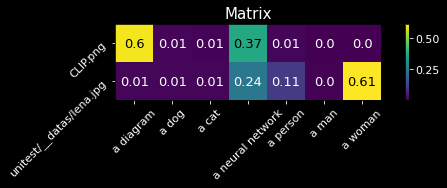

(2, 7)


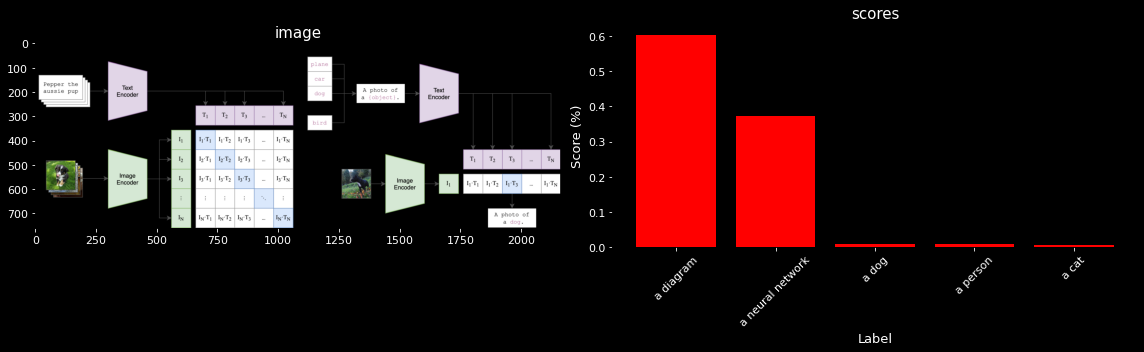

Text #0 (0.60) : a diagram
Text #0 (0.37) : a neural network
Text #0 (0.01) : a dog
Text #0 (0.01) : a person
Text #0 (0.01) : a cat
Text #0 (0.00) : a man
Text #0 (0.00) : a woman


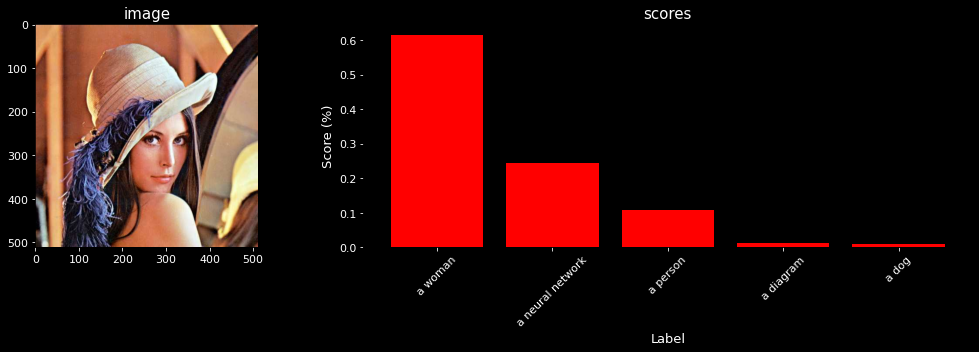

Text #1 (0.61) : a woman
Text #1 (0.24) : a neural network
Text #1 (0.11) : a person
Text #1 (0.01) : a diagram
Text #1 (0.01) : a dog
Text #1 (0.01) : a cat
Text #1 (0.00) : a man


In [6]:
from utils import download_file

filename = download_file('https://raw.github.com/openai/CLIP/main/CLIP.png')

texts    = ["a diagram", "a dog", "a cat", "a neural network", "a person", "a man", "a woman"]
images   = [filename, 'unitest/__datas/lena.jpg']

embed_img = model.embed_image(images)
embed_txt = model.embed_text(texts)

matrix = model.distance(embed_img, embed_txt, pred_matrix = True, pred_probability = True)
plot_matrix(matrix.numpy(), x_labels = texts, y_labels = images, xtick_rotation = 45, factor_size = 1.2)

print(matrix.shape)

for i, image in enumerate(images):
    plot_multiple(
        image = load_image(image),
        scores = {'scores' : matrix[i], 'labels' : texts, 'plot_type' : 'classification'},
        use_subplots = True, y_size = 5, x_size = 8
    )
    for idx in np.flip(tf.argsort(matrix[i])):
        text, score = texts[idx], matrix[i, idx]
        print('Text #{} ({:.2f}) : {}'.format(i, score, text))

### Search image matching text (COCO)

In [5]:
samples = ds.sample(25, random_state = 0)

embed_img = model.embed(samples, use_encoder_a = True)
embed_txt = model.embed(samples, use_encoder_a = False)


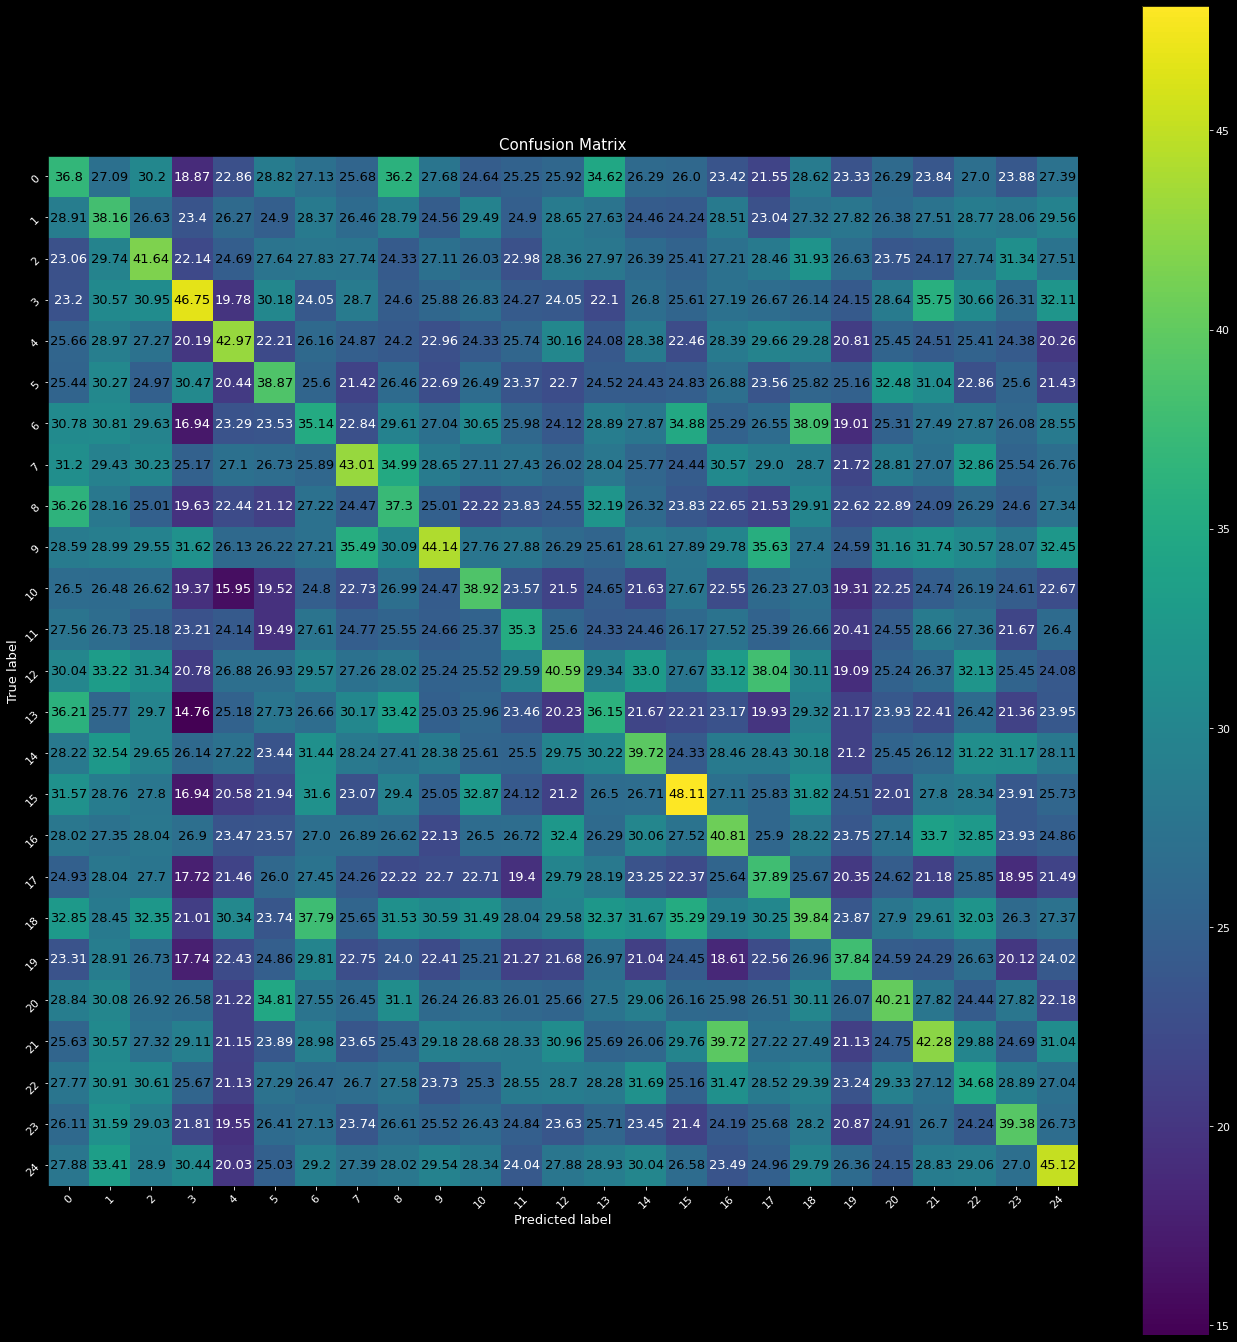

Text : A person on skis going down a mountain slope.
  Score for the correct image : 36.795


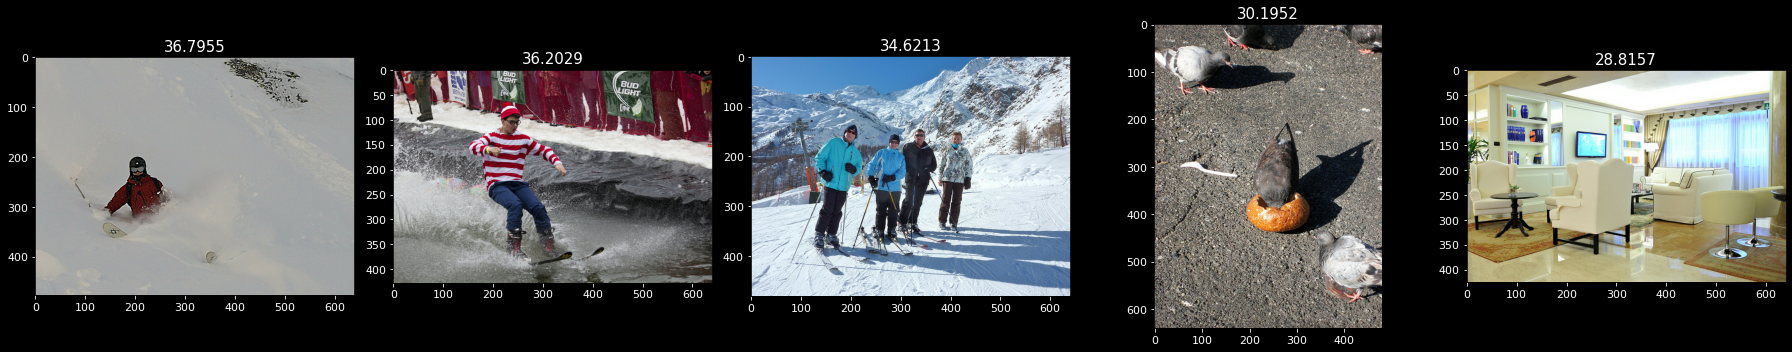

Text : Man in a dress shirt and tie looks in front of him. 
  Score for the correct image : 38.164


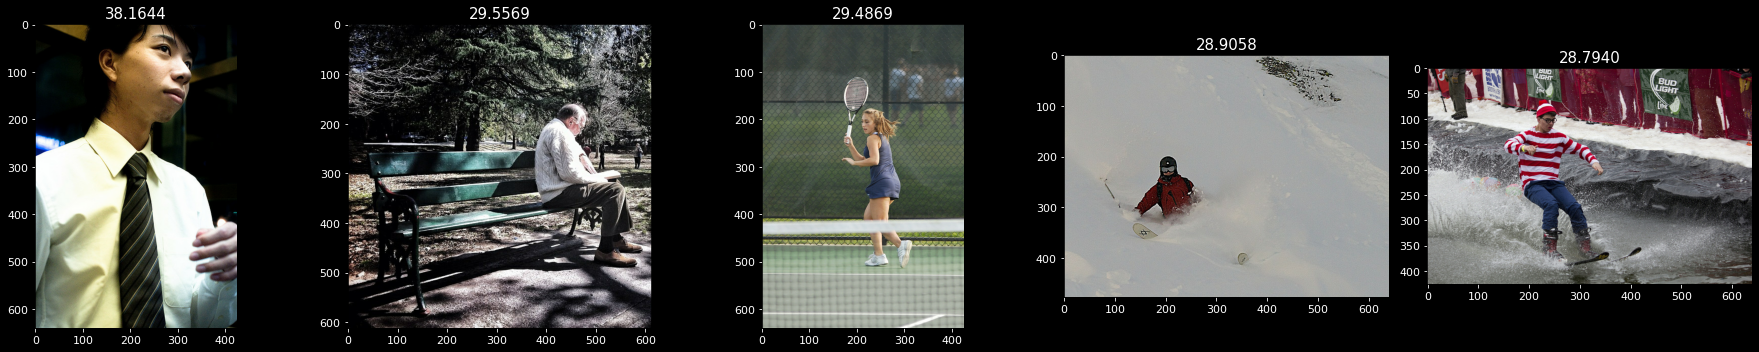

Text : a few birds eating stuff off the ground
  Score for the correct image : 41.639


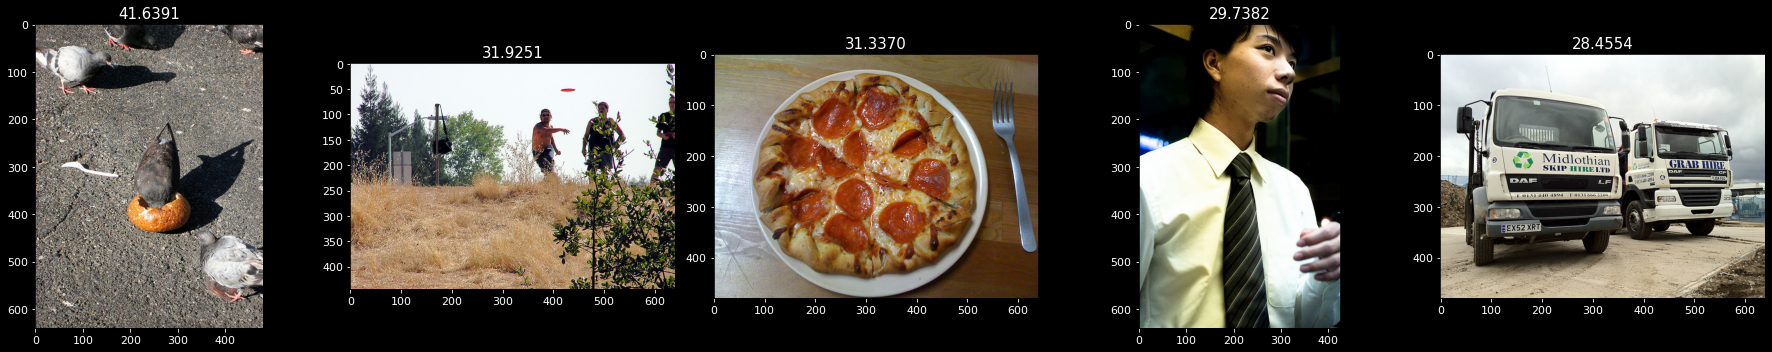

Text : A wooden bench surrounded by potted plants in front of a house.
  Score for the correct image : 46.748


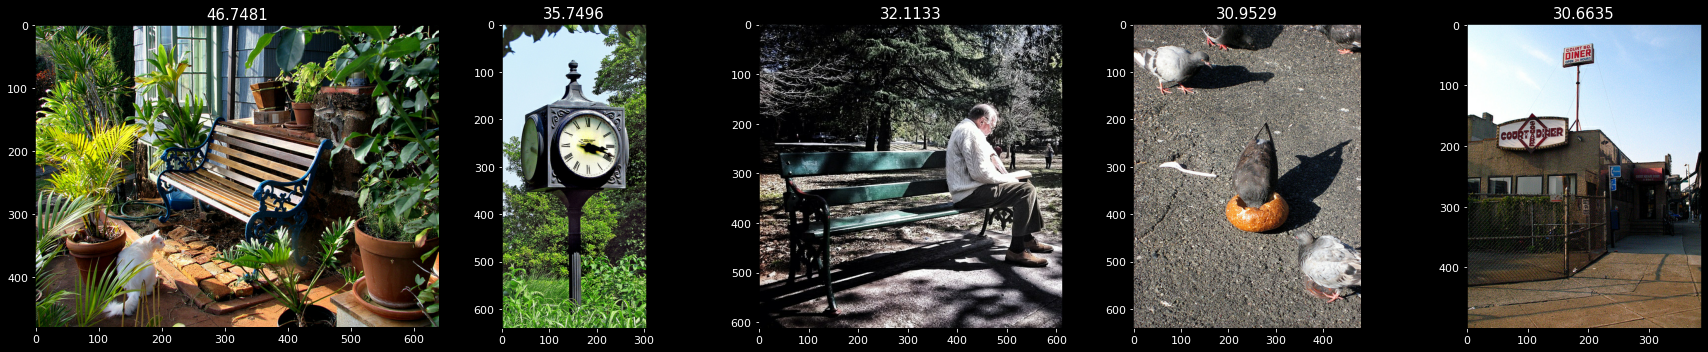

Text : A group of men loading luggage onto an airplane.
  Score for the correct image : 42.967


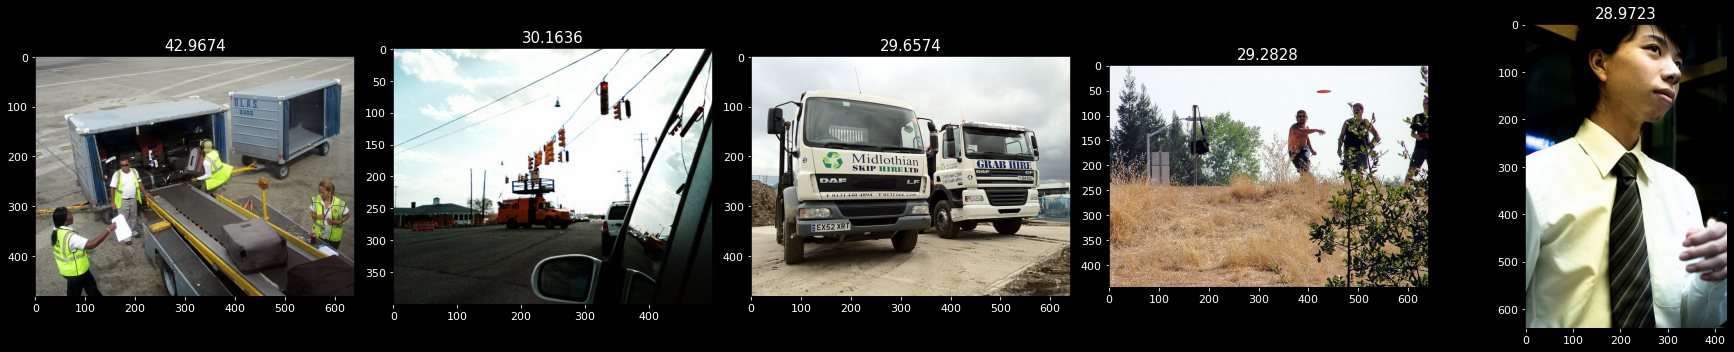

In [10]:
n = 5

matrix = model.distance(embed_img, embed_txt, pred_matrix = True).numpy()
plot_confusion_matrix(matrix, plot_type = 'imshow', with_colorbar = True, norm = False)

for i, ((idx, row), emb1, emb2) in enumerate(zip(samples.iterrows(), embed_img, embed_txt)):
    if i >= n: break
    print('Text : {}\n  Score for the correct image : {:.3f}'.format(row['text'], matrix[i, i]))

    plot_multiple(** {
        '{:.4f}'.format(matrix[i,j]) : load_image(samples.iloc[j]['filename'])
        for j in np.flip(np.argsort(matrix[i]))[:5]
    }, plot_type = 'imshow', ncols = 5)


### Search image matching text (image directory)

In [3]:
from utils import normalize_filename

img_dir = ''

images = normalize_filename(img_dir)

images = [im for im in images if im.endswith(_image_formats)]

embed_img = model.embed_image(images)
print('Embedding shape : {}'.format(embed_img.shape))

Embedding shape : (901, 640)


In [ ]:
# Enter some description you want for the images
texts = [
    
]

embed_txt = model.embed_text(texts)

matrix = model.distance(embed_txt, embed_img, pred_matrix = True, pred_probability = True)
plot_matrix(matrix, y_labels = texts, xtick_rotation = 45, factor_size = 1.2)

print(matrix.shape)

for i, text in enumerate(texts):
    print(text)
    plot_multiple(** {
        '{:.4f}'.format(matrix[i,j]) : load_image(images[j])
        for j in np.flip(np.argsort(matrix[i]))[:5]
    }, plot_type = 'imshow', ncols = 5)
